# Resample images to same size

In [8]:
import sys
sys.path.append('..')
import SimpleITK as sitk
import os
from faimed3d.basics import *
from pathlib import Path
import numpy as np

In this notebook, I will try to adapt spacing, origin and direction in three MRI sequences of the same examination. 

In [9]:
path = Path('/media/ScaleOut/prostata/data/dcm/A0001047141')

In [10]:
t1 = TensorDicom3D.create(path/'T1_map/DICOM')
t2 = TensorDicom3D.create(path/'T2/DICOM')
adc = TensorDicom3D.create(path/'ADC/DICOM')

I will use proprietary patient data from a research project, which cannot be uploaded to GitHub, so the code in this Notebook cannot be tested in the repositories CI. 

https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb

In [11]:
data = [t1.as_sitk(),
        t2.as_sitk(), 
        adc.as_sitk()]

In [12]:
dimension = data[0].GetDimension()

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)
for img in data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]

# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()
reference_size = [512, 512, 25] 
reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

reference_image = sitk.Image(reference_size, data[0].GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

# Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as 
# this takes into account size, spacing and direction cosines. For the vast majority of images the direction 
# cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the 
# spacing will not yield the correct coordinates resulting in a long debugging session. 
reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [25]:
imgs = []
for img in data:
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform = sitk.CompositeTransform([centered_transform, centering_transform])
    # Using the linear interpolator as these are intensity images, if there is a need to resample a ground truth 
    # segmentation then the segmentation image should be resampled using the NearestNeighbor interpolator so that 
    # no new labels are introduced.
    im = sitk.Resample(img, reference_image, centered_transform, sitk.sitkLinear, 0.0)
    im = TensorDicom3D.create(sitk.GetArrayFromImage(im))
    imgs.append(im)

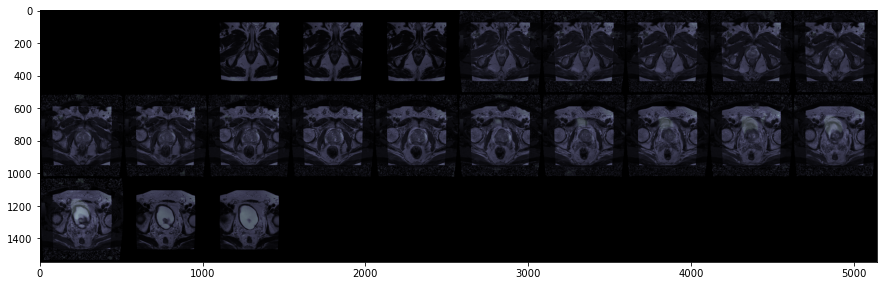

In [28]:
imgs[0].show()
imgs[1].show(add_to_existing=True, alpha = 0.75)

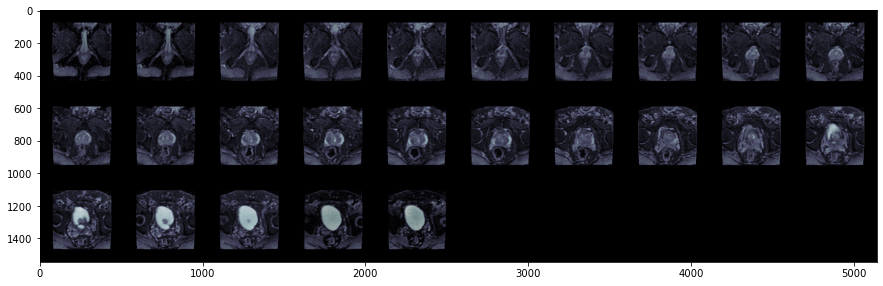

In [29]:
imgs[1].show()
imgs[2].show(add_to_existing=True, alpha = 0.75)

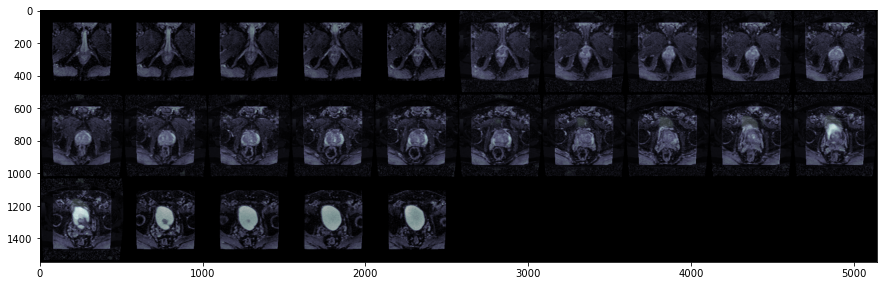

In [30]:
imgs[0].show()
imgs[2].show(add_to_existing=True, alpha = 0.75)